# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.63KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

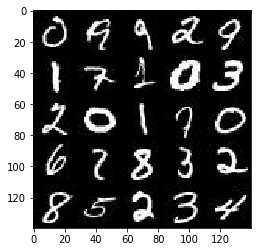

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

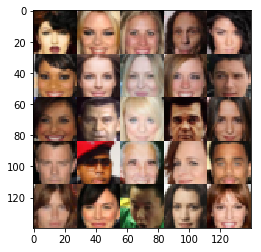

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_img = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learn_rate = tf.placeholder(tf.float32, name='learn_input')

    return real_input_img, z_input, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [40]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        #current size 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 14*14*64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 7*7*128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        #4*4*256
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [50]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*256)
        # Reshape it to start the convolutional stack - 4x4x256
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x56 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [42]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [43]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]


    # Optimize
    with tf.control_dependencies(d_update_ops): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [53]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print(data_shape)
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z,
                                              data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps+=1
                #TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
#                     gen_samples = sess.run(
#                                    generator(input_z, data_shape[3], is_train=False),
#                                    feed_dict={input_z: sample_z})
#                     samples.append(gen_samples)
#                     _ = view_samples(-1, samples, 5, 10, figsize=figsize)
#                     plt.show()
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/3... Discriminator Loss: 0.1661... Generator Loss: 2.3001
Epoch 1/3... Discriminator Loss: 0.1920... Generator Loss: 6.4346
Epoch 1/3... Discriminator Loss: 0.4144... Generator Loss: 5.4247
Epoch 1/3... Discriminator Loss: 0.7444... Generator Loss: 0.8112
Epoch 1/3... Discriminator Loss: 0.4513... Generator Loss: 1.5310
Epoch 1/3... Discriminator Loss: 2.8194... Generator Loss: 0.0897
Epoch 1/3... Discriminator Loss: 0.2482... Generator Loss: 2.1878
Epoch 1/3... Discriminator Loss: 0.4850... Generator Loss: 1.6594
Epoch 1/3... Discriminator Loss: 0.0830... Generator Loss: 4.5512
Epoch 1/3... Discriminator Loss: 0.1632... Generator Loss: 2.7672


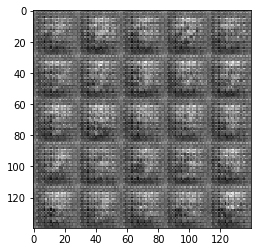

Epoch 1/3... Discriminator Loss: 0.3003... Generator Loss: 2.5248
Epoch 1/3... Discriminator Loss: 0.3664... Generator Loss: 1.8886
Epoch 1/3... Discriminator Loss: 0.9964... Generator Loss: 0.7496
Epoch 1/3... Discriminator Loss: 0.2424... Generator Loss: 2.1207
Epoch 1/3... Discriminator Loss: 0.3264... Generator Loss: 1.8493
Epoch 1/3... Discriminator Loss: 0.2659... Generator Loss: 2.9173
Epoch 1/3... Discriminator Loss: 0.2498... Generator Loss: 2.3826
Epoch 1/3... Discriminator Loss: 0.4213... Generator Loss: 1.4924
Epoch 1/3... Discriminator Loss: 0.1489... Generator Loss: 2.9630
Epoch 1/3... Discriminator Loss: 0.1707... Generator Loss: 2.9196


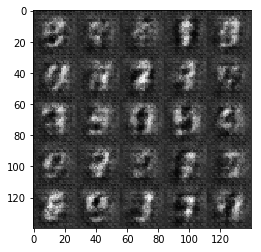

Epoch 1/3... Discriminator Loss: 0.3631... Generator Loss: 1.5442
Epoch 1/3... Discriminator Loss: 0.1990... Generator Loss: 2.2420
Epoch 1/3... Discriminator Loss: 0.7466... Generator Loss: 0.9993
Epoch 1/3... Discriminator Loss: 0.1345... Generator Loss: 3.3845
Epoch 1/3... Discriminator Loss: 0.1110... Generator Loss: 3.0018
Epoch 1/3... Discriminator Loss: 0.1346... Generator Loss: 3.7870
Epoch 1/3... Discriminator Loss: 0.1550... Generator Loss: 3.6778
Epoch 1/3... Discriminator Loss: 1.6679... Generator Loss: 0.3091
Epoch 1/3... Discriminator Loss: 0.2861... Generator Loss: 5.1154
Epoch 1/3... Discriminator Loss: 0.3159... Generator Loss: 1.8622


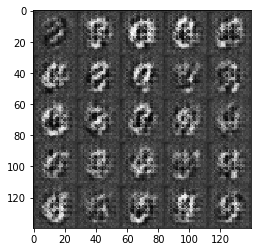

Epoch 1/3... Discriminator Loss: 0.3685... Generator Loss: 1.4894
Epoch 1/3... Discriminator Loss: 0.4038... Generator Loss: 4.4600
Epoch 1/3... Discriminator Loss: 0.2978... Generator Loss: 5.0577
Epoch 1/3... Discriminator Loss: 0.4377... Generator Loss: 3.4335
Epoch 1/3... Discriminator Loss: 0.4421... Generator Loss: 4.0194
Epoch 1/3... Discriminator Loss: 2.0537... Generator Loss: 4.9978
Epoch 1/3... Discriminator Loss: 0.1582... Generator Loss: 2.9782
Epoch 1/3... Discriminator Loss: 0.2067... Generator Loss: 2.6109
Epoch 1/3... Discriminator Loss: 0.1663... Generator Loss: 2.9054
Epoch 1/3... Discriminator Loss: 0.1776... Generator Loss: 2.4857


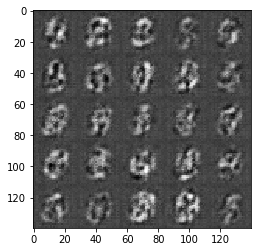

Epoch 1/3... Discriminator Loss: 0.1984... Generator Loss: 2.4211
Epoch 1/3... Discriminator Loss: 0.1831... Generator Loss: 2.5264
Epoch 1/3... Discriminator Loss: 0.1465... Generator Loss: 2.7859
Epoch 1/3... Discriminator Loss: 0.1577... Generator Loss: 2.8129
Epoch 1/3... Discriminator Loss: 0.1249... Generator Loss: 2.8778
Epoch 1/3... Discriminator Loss: 0.1200... Generator Loss: 2.9804
Epoch 2/3... Discriminator Loss: 0.1124... Generator Loss: 3.1919
Epoch 2/3... Discriminator Loss: 0.0985... Generator Loss: 3.4944
Epoch 2/3... Discriminator Loss: 0.1253... Generator Loss: 2.8254
Epoch 2/3... Discriminator Loss: 4.7388... Generator Loss: 10.8411


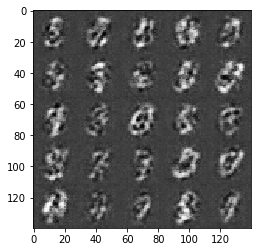

Epoch 2/3... Discriminator Loss: 0.1551... Generator Loss: 3.1796
Epoch 2/3... Discriminator Loss: 0.1650... Generator Loss: 2.7068
Epoch 2/3... Discriminator Loss: 0.1332... Generator Loss: 2.8007
Epoch 2/3... Discriminator Loss: 0.1307... Generator Loss: 2.7507
Epoch 2/3... Discriminator Loss: 0.1380... Generator Loss: 2.8808
Epoch 2/3... Discriminator Loss: 0.1225... Generator Loss: 2.9430
Epoch 2/3... Discriminator Loss: 0.1164... Generator Loss: 3.1831
Epoch 2/3... Discriminator Loss: 0.1100... Generator Loss: 3.0304
Epoch 2/3... Discriminator Loss: 0.0991... Generator Loss: 3.5883
Epoch 2/3... Discriminator Loss: 0.1255... Generator Loss: 2.8435


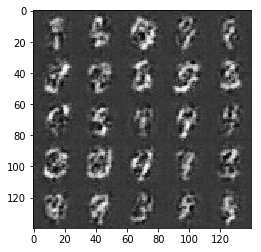

Epoch 2/3... Discriminator Loss: 0.1124... Generator Loss: 3.0930
Epoch 2/3... Discriminator Loss: 0.1168... Generator Loss: 3.1815
Epoch 2/3... Discriminator Loss: 0.1306... Generator Loss: 2.7036
Epoch 2/3... Discriminator Loss: 0.0907... Generator Loss: 3.3493
Epoch 2/3... Discriminator Loss: 0.1118... Generator Loss: 2.8093
Epoch 2/3... Discriminator Loss: 0.1559... Generator Loss: 2.3971
Epoch 2/3... Discriminator Loss: 0.1066... Generator Loss: 2.9653
Epoch 2/3... Discriminator Loss: 0.1073... Generator Loss: 3.0308
Epoch 2/3... Discriminator Loss: 0.0697... Generator Loss: 3.5377
Epoch 2/3... Discriminator Loss: 0.0789... Generator Loss: 3.3766


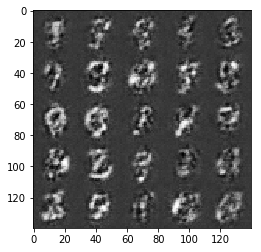

Epoch 2/3... Discriminator Loss: 0.0884... Generator Loss: 3.0662
Epoch 2/3... Discriminator Loss: 0.0824... Generator Loss: 3.2693
Epoch 2/3... Discriminator Loss: 0.1014... Generator Loss: 2.8035
Epoch 2/3... Discriminator Loss: 0.0736... Generator Loss: 3.3365
Epoch 2/3... Discriminator Loss: 0.2588... Generator Loss: 2.4310
Epoch 2/3... Discriminator Loss: 0.4572... Generator Loss: 1.4553
Epoch 2/3... Discriminator Loss: 0.1583... Generator Loss: 2.7293
Epoch 2/3... Discriminator Loss: 0.1425... Generator Loss: 2.6878
Epoch 2/3... Discriminator Loss: 0.1080... Generator Loss: 2.9715
Epoch 2/3... Discriminator Loss: 0.0868... Generator Loss: 3.1203


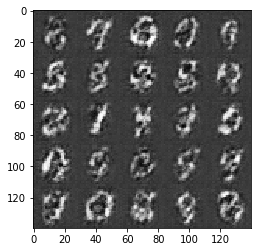

Epoch 2/3... Discriminator Loss: 0.1017... Generator Loss: 2.9730
Epoch 2/3... Discriminator Loss: 0.0771... Generator Loss: 3.3947
Epoch 2/3... Discriminator Loss: 0.0856... Generator Loss: 3.2817
Epoch 2/3... Discriminator Loss: 0.0709... Generator Loss: 3.4214
Epoch 2/3... Discriminator Loss: 0.0722... Generator Loss: 3.4426
Epoch 2/3... Discriminator Loss: 0.0588... Generator Loss: 3.7713
Epoch 2/3... Discriminator Loss: 0.0656... Generator Loss: 3.3933
Epoch 2/3... Discriminator Loss: 0.0654... Generator Loss: 3.4048
Epoch 2/3... Discriminator Loss: 0.0675... Generator Loss: 3.5663
Epoch 2/3... Discriminator Loss: 0.0783... Generator Loss: 3.3734


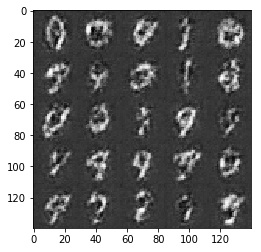

Epoch 2/3... Discriminator Loss: 0.0779... Generator Loss: 3.2372
Epoch 2/3... Discriminator Loss: 0.0895... Generator Loss: 3.1503
Epoch 2/3... Discriminator Loss: 0.0632... Generator Loss: 3.3563
Epoch 3/3... Discriminator Loss: 0.0903... Generator Loss: 2.9856
Epoch 3/3... Discriminator Loss: 0.0638... Generator Loss: 3.4713
Epoch 3/3... Discriminator Loss: 0.0475... Generator Loss: 3.7916
Epoch 3/3... Discriminator Loss: 0.0563... Generator Loss: 3.6659
Epoch 3/3... Discriminator Loss: 0.0602... Generator Loss: 3.4195
Epoch 3/3... Discriminator Loss: 0.0631... Generator Loss: 3.5091
Epoch 3/3... Discriminator Loss: 0.0355... Generator Loss: 4.2511


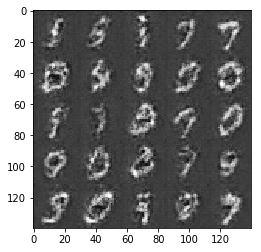

Epoch 3/3... Discriminator Loss: 0.0514... Generator Loss: 3.6425
Epoch 3/3... Discriminator Loss: 0.0568... Generator Loss: 3.5921
Epoch 3/3... Discriminator Loss: 0.0409... Generator Loss: 3.9180
Epoch 3/3... Discriminator Loss: 0.0468... Generator Loss: 3.9585
Epoch 3/3... Discriminator Loss: 0.0747... Generator Loss: 3.4251
Epoch 3/3... Discriminator Loss: 0.0535... Generator Loss: 3.5594
Epoch 3/3... Discriminator Loss: 0.0529... Generator Loss: 4.0324
Epoch 3/3... Discriminator Loss: 0.0538... Generator Loss: 3.5828
Epoch 3/3... Discriminator Loss: 0.0873... Generator Loss: 2.9182
Epoch 3/3... Discriminator Loss: 0.0539... Generator Loss: 3.7311


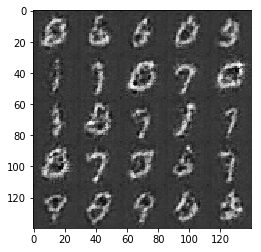

Epoch 3/3... Discriminator Loss: 0.0614... Generator Loss: 3.3303
Epoch 3/3... Discriminator Loss: 0.1039... Generator Loss: 2.9073
Epoch 3/3... Discriminator Loss: 0.1249... Generator Loss: 2.6781
Epoch 3/3... Discriminator Loss: 1.7254... Generator Loss: 3.1870
Epoch 3/3... Discriminator Loss: 0.7253... Generator Loss: 2.5982
Epoch 3/3... Discriminator Loss: 0.3994... Generator Loss: 1.5335
Epoch 3/3... Discriminator Loss: 0.2561... Generator Loss: 2.6399
Epoch 3/3... Discriminator Loss: 0.3052... Generator Loss: 1.7477
Epoch 3/3... Discriminator Loss: 0.1788... Generator Loss: 2.5087
Epoch 3/3... Discriminator Loss: 0.1414... Generator Loss: 2.5419


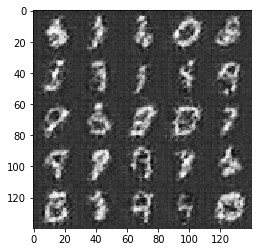

Epoch 3/3... Discriminator Loss: 0.1763... Generator Loss: 2.2952
Epoch 3/3... Discriminator Loss: 0.1390... Generator Loss: 2.5608
Epoch 3/3... Discriminator Loss: 0.1511... Generator Loss: 2.6132
Epoch 3/3... Discriminator Loss: 0.1310... Generator Loss: 2.6429
Epoch 3/3... Discriminator Loss: 0.1107... Generator Loss: 2.6951
Epoch 3/3... Discriminator Loss: 0.0452... Generator Loss: 3.9929
Epoch 3/3... Discriminator Loss: 0.0936... Generator Loss: 2.9513
Epoch 3/3... Discriminator Loss: 0.1793... Generator Loss: 2.4416
Epoch 3/3... Discriminator Loss: 0.0369... Generator Loss: 4.5255
Epoch 3/3... Discriminator Loss: 0.0867... Generator Loss: 3.0235


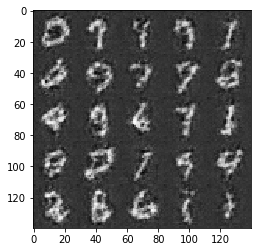

Epoch 3/3... Discriminator Loss: 0.0678... Generator Loss: 3.3721
Epoch 3/3... Discriminator Loss: 0.0852... Generator Loss: 3.1768
Epoch 3/3... Discriminator Loss: 0.1339... Generator Loss: 2.6943
Epoch 3/3... Discriminator Loss: 0.0746... Generator Loss: 3.2182
Epoch 3/3... Discriminator Loss: 0.0971... Generator Loss: 3.0446
Epoch 3/3... Discriminator Loss: 0.0537... Generator Loss: 3.5767
Epoch 3/3... Discriminator Loss: 0.0556... Generator Loss: 3.7756
Epoch 3/3... Discriminator Loss: 0.0588... Generator Loss: 3.4863
Epoch 3/3... Discriminator Loss: 0.1177... Generator Loss: 2.5482
Epoch 3/3... Discriminator Loss: 0.0432... Generator Loss: 4.0377


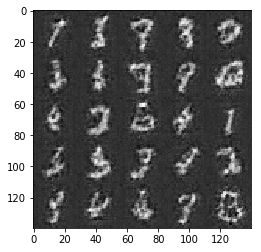

In [54]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.